In [46]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from benchmark_utils import *

from typing import List, TextIO


In [47]:

def load_df(filename = "lsd_score.json"):
    keys = []
    values = []
    with open(filename) as json_file:
        data = json.load(json_file)
        for method, v0 in data.items():
            for dataset, v1 in v0.items():
                for dataset_type, v2 in v1.items():
                    for sample, v3 in v2.items():
                        for eval_method, v4 in v3.items():
                            for metric, value in v4.items():
                                metric = eval_method + "-" + metric
                                keys.append([method, dataset, dataset_type, sample, metric])
                                values.append(value) 
    df = pd.DataFrame(keys, columns=["Method", "Dataset", "Dataset Type", "Sample", "Metric"], dtype="category")
    df["Value"] = pd.Series(values)
    df["Dataset"].cat.categories
    df.dropna(axis=0, inplace=True)
    return df

df = load_df()
TrackersNames = ['Double exponential', 'EMA', 'Kalman', 'Last observation', 'One euro', 'SMA']
SOTANames = ['AG3Line', 'CannyLines', 'EDLines', 'ELSED', 'Hough', 'Kalman', 'LSD', 'LSD (II)']

dict_result_names = {
    'Last observation': 'Last observation',
    'Double exponential': 'Double exponential',
    'EMA': 'EMA',
    'SMA': 'SMA',
    'Kalman': 'Kalman',
    'One euro': 'One euro',
    'ag3line': 'AG3Line',
    'cannylines': 'CannyLines',
    'edlines': 'EDLines',
    'elsed': 'ELSED',
    'ocv_hough': 'Hough',
    'lsd': 'LSD',
    'lsd_m': 'LSD (II)',
}

df['Method'] = df['Method'].map(dict_result_names)

## Annuaires

In [48]:
df_annuaires = df[df["Dataset"] == "trade_directories"]
df_annuaires

,Method,Dataset,Dataset Type,Sample,Metric,Value
28210,EDLines,trade_directories,train,Bottin1_1827-0372.in,lem-precision,0.922821
28211,EDLines,trade_directories,train,Bottin1_1827-0372.in,lem-recall,0.829991
28212,EDLines,trade_directories,train,Bottin1_1827-0372.in,lem-iou,0.907632
28213,EDLines,trade_directories,train,Bottin1_1827-0372.in,lem-fscore,0.873948
28214,EDLines,trade_directories,train,Bottin1_1827-0372.in,lems-precision,0.329578
...,...,...,...,...,...,...
427499,One euro,trade_directories,test,Didot_1851b-0003.in,lems-precision,0.907897
427500,One euro,trade_directories,test,Didot_1851b-0003.in,lems-recall,0.900655
427501,One euro,trade_directories,test,Didot_1851b-0003.in,lems-iou,0.907326
427502,One euro,trade_directories,test,Didot_1851b-0003.in,lems-fscore,0.904261


# Music Sheets

In [49]:
df_ms = df[df["Dataset"] == "music_sheets"]
df_ms.head(10)

,Method,Dataset,Dataset Type,Sample,Metric,Value
223953,Last observation,music_sheets,train,0015,coco-PQ,0.893396
223954,Last observation,music_sheets,train,0015,coco-SQ,0.923176
223955,Last observation,music_sheets,train,0015,coco-RQ,0.967742
223956,Last observation,music_sheets,train,0015,icdar2013-precision,0.994962
223957,Last observation,music_sheets,train,0015,icdar2013-recall,0.977558
223958,Last observation,music_sheets,train,0015,icdar2013-fscore,0.986183
223967,Last observation,music_sheets,train,1238,coco-PQ,0.865306
223968,Last observation,music_sheets,train,1238,coco-SQ,0.909681
223969,Last observation,music_sheets,train,1238,coco-RQ,0.951220
223970,Last observation,music_sheets,train,1238,icdar2013-precision,0.973059


# ICDAR 2023

## Boxplots

In [50]:
def compute_boxplots(df: pd.DataFrame) -> None:
    """
    Compute boxplots for all the metrics

    :param df: dataframe
    :return: None
    """
    df = df.copy()
    #df.drop(columns=['file'], inplace=True)
    df.Metric.cat.remove_unused_categories(inplace=True)
    for m in df.Metric.cat.categories:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        for i, t in enumerate(['train', 'test']):
            tmp = df[(df.Metric == m) & (df["Dataset Type"] == t)]
            tmp.boxplot(column='Value', by='Method', ax=ax[i], rot=90)
            ax[i].set_title(f"{m} - {t}")
    plt.show()


/tmp/ipykernel_10414/1852561404.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df.Metric.cat.remove_unused_categories(inplace=True)


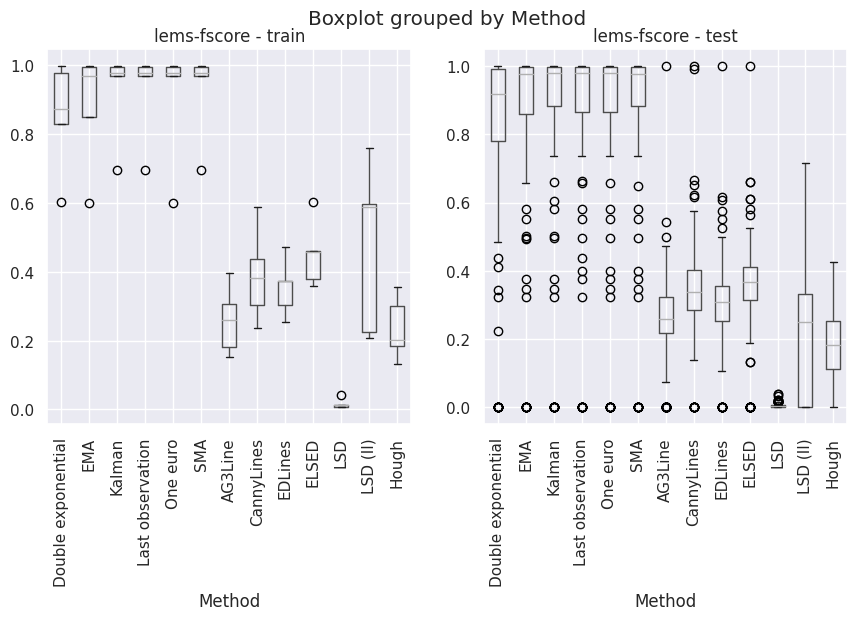

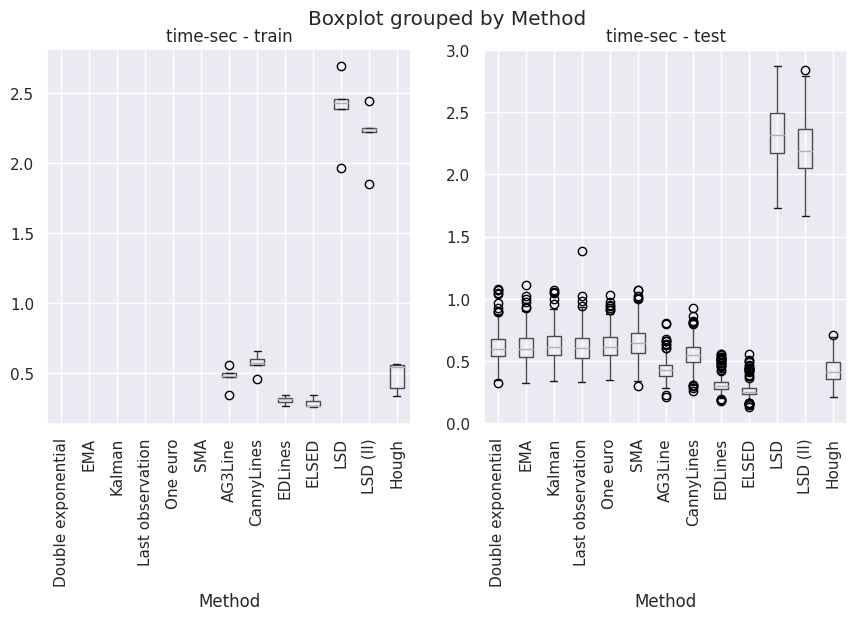

In [51]:
sel = df_annuaires.Metric.isin(["lems-fscore","time-sec"])
compute_boxplots(df_annuaires[sel])


/tmp/ipykernel_10414/1852561404.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df.Metric.cat.remove_unused_categories(inplace=True)


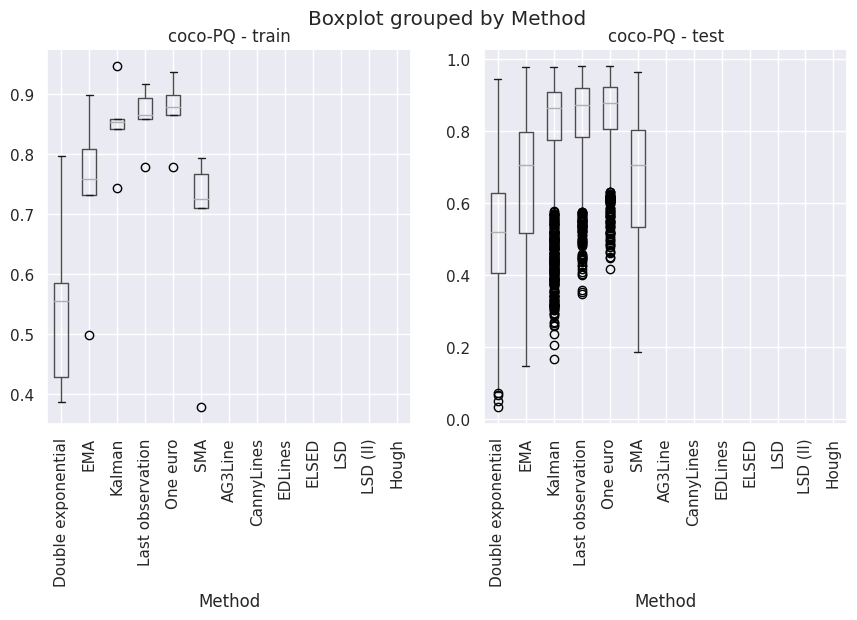

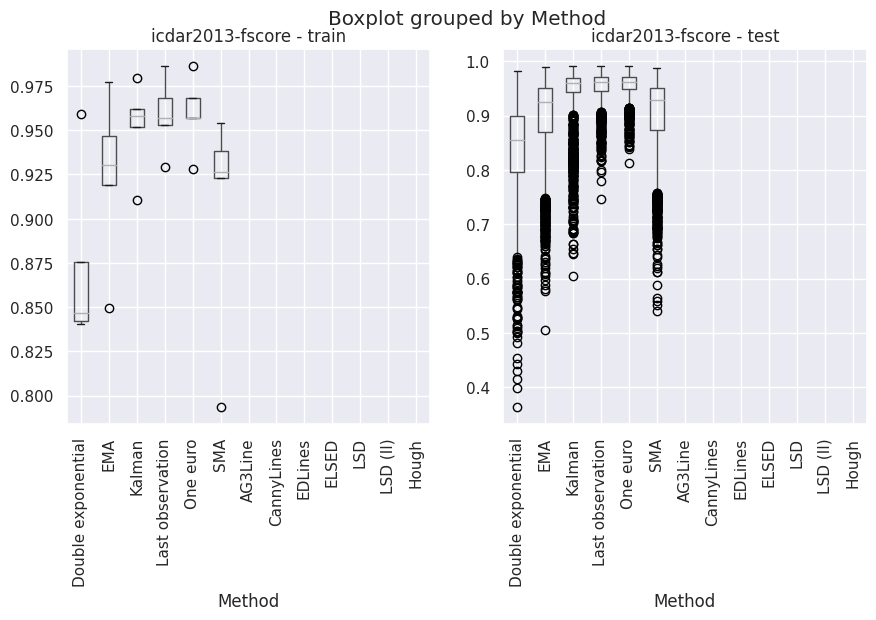

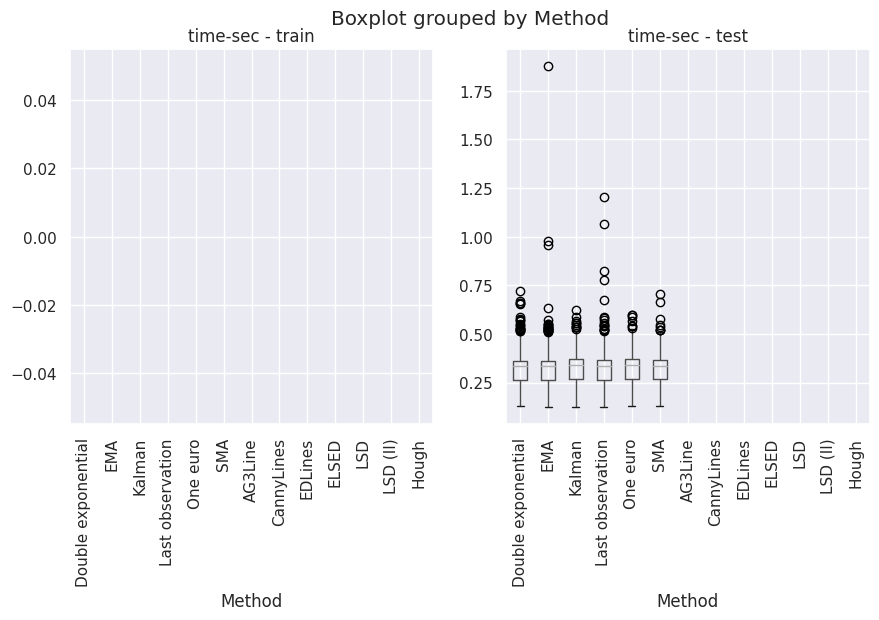

In [52]:
sel = df_ms.Metric.isin(["coco-PQ", "icdar2013-fscore", "time-sec"])
compute_boxplots(df_ms[sel])


## Graphs

## Tables

### Dataframe

In [53]:
def print_table(df: pd.DataFrame):
    df = df.copy()
    df["Metric"].cat.remove_unused_categories(inplace=True)
    df["Method"].cat.remove_unused_categories(inplace=True)
    stats = df.groupby(["Metric", "Method"]).agg(["mean", "std"])
    times = (stats.loc["time-sec"] * 1000).round(0).astype(int)
    stats = df.groupby(["Method", "Dataset Type", "Metric"]).agg(["mean", "std"])
    stats = stats.droplevel(level=0,axis=1)
    stats = stats.unstack().swaplevel(1,0, axis=1)

    cols = list(stats.columns.get_level_values(0).categories)
    cols.remove("time-sec")
    fscores = (stats[cols[0]] * 100).round(1)
    fscores_2 = (stats[cols[1]] * 100).round(1)
    fmt = lambda s: "{} ($\pm$ {})".format(s.iloc[0], s.iloc[1])
    boldstr = '\textbf{{{}}}'.format
    def boldify(table, pos): table.loc[pos] = table.loc[pos].applymap(boldstr)

    max_pos = fscores["mean"].unstack(level=-1).idxmax()
    fscores = fscores.agg(fmt, axis=1)
    fscores = fscores.unstack()[["train","test"]]
    boldify(fscores, max_pos)

    max_pos = fscores_2["mean"].unstack(level=-1).idxmax()
    fscores_2 = fscores_2.agg(fmt, axis=1)
    fscores_2 = fscores_2.unstack()[["train","test"]]
    boldify(fscores_2, max_pos)

    max_pos = times["Value"]["mean"].idxmin()
    times = times.agg(fmt, axis=1)
    times[max_pos] = boldstr(times[max_pos])

    R = pd.concat([times, fscores, fscores_2], axis=1, keys=("Duration (ms)", cols[0], cols[1]), names=["Metric", "Category"])
    #R.columns = R.columns.reorder_levels([1,0])
    return R



In [54]:
metrics = ["lem-fscore", "lems-fscore", "time-sec"]
sel = df_annuaires["Metric"].isin(metrics) & df_annuaires.Method.isin(TrackersNames)
table_annuaires = print_table(df_annuaires[sel])
table_annuaires



/tmp/ipykernel_10414/1045366187.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Metric"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Method"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:5: FutureWarning: ['Dataset', 'Dataset Type', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = df.groupby(["Metric", "Method"]).agg(["mean", "std"])
/tmp/ipykernel_10414/1045366187.py:7: FutureWarning: ['Dataset', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


Metric                         Duration (ms)                 lem-fscore  \
Category                                   0                      train   
Method                                                                    
Double exponential           621 ($\pm$ 141)           94.6 ($\pm$ 7.2)   
EMA                          615 ($\pm$ 134)           92.6 ($\pm$ 8.6)   
Kalman                       630 ($\pm$ 140)  \textbf{95.2 ($\pm$ 7.5)}   
Last observation    \textbf{614 ($\pm$ 145)}           95.2 ($\pm$ 7.5)   
One euro                     625 ($\pm$ 129)           95.2 ($\pm$ 7.5)   
SMA                          650 ($\pm$ 150)           95.2 ($\pm$ 7.5)   

Metric                                                         lems-fscore  \
Category                                  test                       train   
Method                                                                       
Double exponential           87.3 ($\pm$ 25.6)           85.6 ($\pm$ 15.9)   
EMA                          89.7 ($\pm$ 24.3)           88.3 ($\pm$ 16.9)   
Kalman              \textbf{90.1 ($\pm$ 24.0)}  \textbf{92.7 ($\pm$ 13.0)}   
Last observation             90.0 ($\pm$ 24.1)           92.7 ($\pm$ 13.0)   
One euro                     90.1 ($\pm$ 24.0)           90.8 ($\pm$ 17.2)   
SMA                          90.0 ($\pm$ 24.0)           92.7 ($\pm$ 13.0)   

Metric                                          
Category                                  test  
Method                                          
Double exponential           81.7 ($\pm$ 26.4)  
EMA                          86.5 ($\pm$ 24.8)  
Kalman              \textbf{87.6 ($\pm$ 24.6)}  
Last observation             87.2 ($\pm$ 24.7)  
One euro                     87.2 ($\pm$ 24.7)  
SMA                          87.4 ($\pm$ 24.7)

In [55]:
metrics = ["lem-fscore", "lems-fscore", "time-sec"]

sel = df_annuaires["Metric"].isin(metrics) & df_annuaires.Method.isin(SOTANames)
table_annuaires_2 = print_table(df_annuaires[sel])
table_annuaires_2



/tmp/ipykernel_10414/1045366187.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Metric"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Method"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:5: FutureWarning: ['Dataset', 'Dataset Type', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = df.groupby(["Metric", "Method"]).agg(["mean", "std"])
/tmp/ipykernel_10414/1045366187.py:7: FutureWarning: ['Dataset', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


Metric                Duration (ms)                 lem-fscore  \
Category                          0                      train   
Method                                                           
Kalman              630 ($\pm$ 140)  \textbf{95.2 ($\pm$ 7.5)}   
AG3Line              434 ($\pm$ 90)          66.2 ($\pm$ 23.8)   
CannyLines          551 ($\pm$ 123)          81.2 ($\pm$ 22.7)   
EDLines              314 ($\pm$ 79)          83.2 ($\pm$ 23.6)   
ELSED       \textbf{264 ($\pm$ 70)}          91.1 ($\pm$ 11.3)   
LSD                2338 ($\pm$ 232)          18.7 ($\pm$ 10.3)   
LSD (II)           2206 ($\pm$ 224)          76.7 ($\pm$ 28.6)   
Hough               419 ($\pm$ 111)          80.5 ($\pm$ 14.5)   

Metric                                                 lems-fscore  \
Category                          test                       train   
Method                                                               
Kalman      \textbf{90.1 ($\pm$ 24.0)}  \textbf{92.7 ($\pm$ 13.0)}   
AG3Line              72.5 ($\pm$ 35.4)            25.9 ($\pm$ 9.9)   
CannyLines           84.4 ($\pm$ 24.2)           39.0 ($\pm$ 13.5)   
EDLines              87.4 ($\pm$ 24.0)            35.5 ($\pm$ 8.3)   
ELSED                87.0 ($\pm$ 26.6)            45.3 ($\pm$ 9.6)   
LSD                   12.5 ($\pm$ 8.5)             1.6 ($\pm$ 1.5)   
LSD (II)             53.3 ($\pm$ 43.7)           47.6 ($\pm$ 24.7)   
Hough                64.8 ($\pm$ 30.0)            23.5 ($\pm$ 9.2)   

Metric                                  
Category                          test  
Method                                  
Kalman      \textbf{87.6 ($\pm$ 24.6)}  
AG3Line              24.2 ($\pm$ 13.7)  
CannyLines           34.2 ($\pm$ 14.0)  
EDLines              30.5 ($\pm$ 12.3)  
ELSED                35.2 ($\pm$ 13.7)  
LSD                    0.5 ($\pm$ 0.6)  
LSD (II)             20.7 ($\pm$ 17.9)  
Hough                18.2 ($\pm$ 10.1)

In [56]:

metrics = ["coco-PQ", "icdar2013-fscore", "time-sec"]
sel = df_ms["Metric"].isin(metrics) & df_ms.Method.isin(TrackersNames)
table_ms = print_table(df_ms[sel])
table_ms


/tmp/ipykernel_10414/1045366187.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Metric"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df["Method"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/1045366187.py:5: FutureWarning: ['Dataset', 'Dataset Type', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = df.groupby(["Metric", "Method"]).agg(["mean", "std"])
/tmp/ipykernel_10414/1045366187.py:7: FutureWarning: ['Dataset', 'Sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


Metric                        Duration (ms)                    coco-PQ  \
Category                                  0                      train   
Method                                                                   
Double exponential  \textbf{320 ($\pm$ 72)}          55.1 ($\pm$ 16.1)   
EMA                          322 ($\pm$ 82)          74.0 ($\pm$ 14.9)   
Kalman                       328 ($\pm$ 71)           84.9 ($\pm$ 7.2)   
Last observation             323 ($\pm$ 77)           86.3 ($\pm$ 5.2)   
One euro                     327 ($\pm$ 72)  \textbf{87.2 ($\pm$ 5.9)}   
SMA                          324 ($\pm$ 70)          67.5 ($\pm$ 16.9)   

Metric                                                  icdar2013-fscore  \
Category                                 test                      train   
Method                                                                     
Double exponential          51.7 ($\pm$ 15.8)           87.3 ($\pm$ 5.0)   
EMA                         65.5 ($\pm$ 18.4)           92.5 ($\pm$ 4.7)   
Kalman                      80.7 ($\pm$ 15.6)           95.2 ($\pm$ 2.5)   
Last observation            83.7 ($\pm$ 11.1)  \textbf{95.9 ($\pm$ 2.1)}   
One euro            \textbf{85.1 ($\pm$ 9.6)}  \textbf{95.9 ($\pm$ 2.1)}   
SMA                         66.0 ($\pm$ 17.6)           90.7 ($\pm$ 6.5)   

Metric                                         
Category                                 test  
Method                                         
Double exponential           83.8 ($\pm$ 8.6)  
EMA                          89.6 ($\pm$ 7.7)  
Kalman                       94.1 ($\pm$ 5.6)  
Last observation    \textbf{95.4 ($\pm$ 2.7)}  
One euro            \textbf{95.7 ($\pm$ 2.2)}  
SMA                          89.9 ($\pm$ 7.4)

### Latex

In [57]:
import sys

def compute_latex(table: pd.DataFrame, labels: List[str], caption: str, label: str = "FIXME", file : TextIO = sys.stdout):
    """
    Compute and save latex table from pandas dataframe

    :param table: pandas dataframe
    :param labels: list of labels to keep
    :param file: name of the file to save
    :param caption: caption of the table    
    """
    #table = table.loc[labels]

    txt = table.style.to_latex(position='!ht', multicol_align='l',
                               multirow_align='l', caption=caption, label=f"table:{label}")

    txt = txt.replace('{ll', '{rl')
    txt = txt.replace('lll}', 'lll}\n\\hline')
    txt = txt.replace('\\caption', '\n\\caption')
    txt = txt.replace("\n &  &  &  &  &  \\\\", "")
    txt = txt.replace("\t", "\\t")
    txt = txt.replace("\nmethod &  &  &  &  &  \\\\", "")
    txt = txt.replace("_", "\_")

    for last_char in ['O', 'S']:
        txt = txt.replace(f"{last_char} \\\\", f"{last_char} \\\\\n\\hline")

    txt = txt.replace('\\\\\n\\hline', "\\\\\n\\hline")
    txt = txt.replace(']\n', ']\n\\setlength{\\tabcolsep}{5pt}')
    txt = txt.replace('\\end{tabular}', '\\hline\n\\end{tabular}')
    txt = txt.replace('pylene', '\\textbf{pylene}')

    file.write(txt)


In [58]:
compute_latex(table_annuaires, predictor_labels, 'TODO', label = "dir-tracker", file = open('dir_tracker.tex', 'w'))

In [59]:
compute_latex(table_annuaires_2, sta_labels, 'TODO', label = "dir-sota", file = open('dir_sota.tex', 'w'))


In [60]:
compute_latex(table_ms, predictor_labels, 'TODO', label = "ms-tracker", file = open('ms_tracker.tex', 'w'))


# Precision-recall graph

In [63]:
import seaborn as sns
sns.set_theme()
trackers = ['Double exponential', 'EMA', 'Kalman', 'Last observation', 'One euro', 'SMA']
metrics = ["lems-precision", "lems-recall", "lems-fscore"]

/tmp/ipykernel_10414/4281903308.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  P = df_annuaires[sel].pivot(columns="Metric", values="Value", index=["Method","Sample"])
/tmp/ipykernel_10414/4281903308.py:11: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  Trackers["Method"].cat.remove_unused_categories(inplace=True)
/tmp/ipykernel_10414/4281903308.py:20: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  Others["Method"].cat.remove_unused_categories(inplace=True)


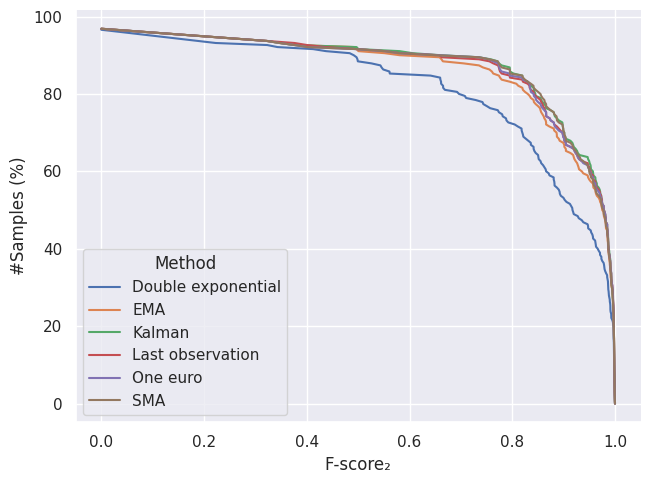

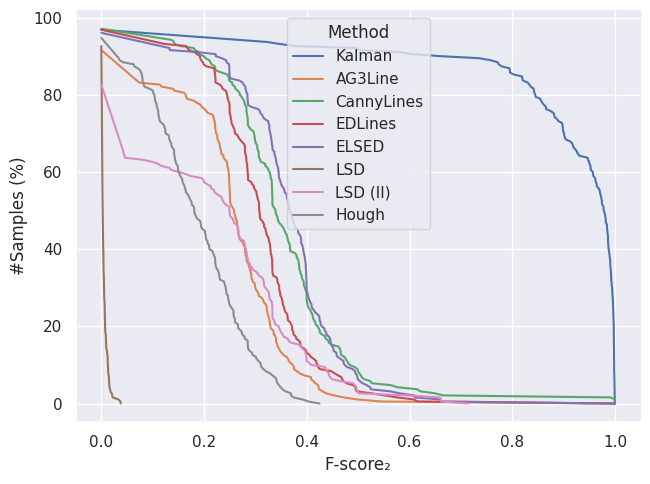

In [64]:
sel = df["Metric"].isin(metrics) & (df["Dataset Type"] == "test")
P = df_annuaires[sel].pivot(columns="Metric", values="Value", index=["Method","Sample"])
P.reset_index(inplace=True)
#P["Method"].cat.remove_unused_categories(inplace=True)
rank = P.groupby(by="Method")["lems-fscore"].rank()
P["Rank"] = 100 - rank / rank.max() * 100
P["Tracker"] = P["Method"].isin(trackers)
P.dropna(axis=0, inplace=True) 

Trackers = P[P["Tracker"]]
Trackers["Method"].cat.remove_unused_categories(inplace=True)

g = sns.relplot(data=Trackers, x="lems-fscore", y="Rank", kind="line", hue="Method", aspect=4/3, facet_kws={"legend_out" : False})
g.set_xlabels("F-score₂")
g.set_ylabels("#Samples (%)")
g.savefig("dir_tracker.pdf")


Others = P[~P["Tracker"] | (P["Method"] == "Kalman")]
Others["Method"].cat.remove_unused_categories(inplace=True)

g = sns.relplot(data=Others, x="lems-fscore", y="Rank", kind="line", hue="Method", aspect=4/3, facet_kws={"legend_out" : False})
g.set_xlabels("F-score₂")
g.set_ylabels("#Samples (%)")
g.savefig("dir_sota.pdf")


#sns.move_legend(g, "upp)
